# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors of those images over the test set. You should use and compare the following feature representations for the nearest neighbors:
1. fc7 features from the ResNet (finetuned from ImageNet)
2. pool5 features from the CaffeNet (trained from scratch)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
from voc_dataset import VOCDataset
import trainer
import utils
import numpy as np
from utils import ARGS

from sklearn.manifold import TSNE
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset
import os
from sklearn.neighbors import NearestNeighbors

%env CUDA_VISIBLE_DEVICES=1
# load images, calculate nearest neighbors, and plot

env: CUDA_VISIBLE_DEVICES=1


In [4]:
class PretrainedResNetNew(nn.Module):
    def __init__(self):
        super().__init__()
        
        model=PretrainedResNet()
        PATH = 'PretrainedResNet/models/40_.pt'
        model.load_state_dict(torch.load(PATH))

        self.classifier = nn.Sequential(*list(model.pretrained_resnet.children())[:-1])
        
        

    def forward(self, x):
#         x=model(x)
        x=self.classifier(x)
        return x
    
    def get_embeddings(self, x):
        return self.forward(x)

class PretrainedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_resnet = models.resnet18(pretrained=True)
        num_classes= len(VOCDataset.CLASS_NAMES)
        self.fc = nn.Sequential(
                      nn.Linear(1000, num_classes,bias=True))
#                       nn.LogSoftmax(dim=1))
        
    
    def forward(self, x):
        x=self.pretrained_resnet(x)
        out=self.fc(x)
        return out

class CaffeNet(nn.Module):
    def __init__(self):
        super().__init__()
        conv1 = [nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4,padding=0,bias=True)]
                      
        self.conv_first = nn.Sequential(*conv1)
        
        self.conv1_features = [] #epoch,features of filters
        conv_layers = [
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3,stride=2),
                       nn.Conv2d(in_channels=96,out_channels=256,stride=1,kernel_size=5,padding=2,bias=True),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3,stride=2),
                       
                       nn.Conv2d(in_channels=256,out_channels=384,stride=1,kernel_size=3,padding=1,bias=True),
                       nn.ReLU(inplace=True),
                       
                       nn.Conv2d(in_channels=384,out_channels=384,stride=1,kernel_size=3,padding=1,bias=True),
                       nn.ReLU(inplace=True),
                       
                       nn.Conv2d(in_channels=384,out_channels=256,stride=1,kernel_size=3,padding=1,bias=True),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3,stride=2)
                      ]
        self.conv_layers = nn.Sequential(*conv_layers)
        fc = [nn.Linear(256*11*11,4096,bias=True),
             nn.ReLU(inplace=True),
             nn.Dropout(0.5),
             
            nn.Linear(4096,4096,bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
              
              nn.Linear(4096,20,bias=True)
             ]
        self.fc_layers = nn.Sequential(*fc)
#         self.conv_first.register_forward_hook(self.save_outputs_hook())
        
#     def save_outputs_hook(self):
#         def hook(model,inp, output):
#             self.conv1_features.append(output.detach())
#         return hook
    
    
    def forward(self, x):
        x=self.conv_first(x)
        x=self.conv_layers(x)
        x=torch.flatten(x,start_dim=1)
        out=self.fc_layers(x)
        return out
    def get_embeddings(self,x):
        x=self.conv_first(x)
        x=self.conv_layers(x)
        return x.reshape(-1,1)
        
        

class CaffeNetNew(nn.Module):
    def __init__(self):
        super().__init__()
        pretrained_model = CaffeNet()
        PATH = 'CaffeNet/models/49_.pt'
        pretrained_model.load_state_dict(torch.load(PATH))
        
        self.classifier = nn.Sequential(*list(pretrained_model.children())[:-3])
    
    def forward(self, x):
        x=self.conv_first(x)
        x=self.conv_layers(x)
        x=torch.flatten(x,start_dim=1)
        out=self.fc_layers(x)
        return out
    def get_embeddings(self,x):
        return self.classifier(x)

In [5]:
def load_data(model):
    args = ARGS(epochs=50, use_cuda=True,batch_size=32,test_batch_size=100, lr=0.0001,val_every=250,gamma=0.95,save_freq=5)
    test_loader = utils.get_data_loader('voc', train=False, batch_size=args.test_batch_size, split='test')
    wt = []
    target_ = []
    
    embeddings = []
    imgs=[]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target, wgt) in enumerate(test_loader):
            output = model.get_embeddings(data)
#             output = model(data)
            data, target, wgt = data.to(args.device), target.to(args.device), wgt.to(args.device)
            
            imgs.append(data.detach().cpu().numpy())
            embeddings.append(output.detach().cpu().numpy())
            target_.append(target.detach().cpu().numpy())
            wt.append(wgt.detach().cpu().numpy())
    # embeddings = np.array(embeddings)
    embeddings = np.row_stack(embeddings)
    embeddings = embeddings.reshape(embeddings.shape[0], -1)
    imgs = np.row_stack(imgs)
    target_ = np.row_stack(target_)
    wt = np.row_stack(wt)
    return embeddings,imgs,target_




In [6]:
def get_nearestNeighbours(embeddings,imgs,target_):
    random_images_index=[235,225,345]
    class_ind=[np.argmax(target_[idx]) for idx in random_images_index]
    CLASS_NAMES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
                       'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
                       'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
    

    knn = NearestNeighbors(n_neighbors=5)
    knn.fit(embeddings)
    
    for x in random_images_index:
        neighbours = knn.kneighbors(embeddings[x].reshape(1, -1), return_distance=False)
        fig = plt.figure(figsize=(25,5))
        fig.suptitle('Nearest Neighbours for {} for {}'.format(model.__class__.__name__,CLASS_NAMES[np.argmax(target_[x])]))
        plt.subplot(1,5,1)
        plt.axis("off")
        image = (imgs[x].transpose(1,2,0) * np.array([0.229, 0.224, 0.225]))+np.array([0.485, 0.456, 0.406])

        image = np.clip(image, 0,1)
        plt.imshow(image)
        for idx,fn in enumerate(neighbours[neighbours!=x]):
            plt.subplot(1,5,idx+2)
            plt.axis("off")
            image = (imgs[fn].transpose(1,2,0) * np.array([0.229, 0.224, 0.225]))+np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0,1)
            plt.imshow(image)
        plt.show()
#     print("Nearest Neighbours of " + str(index_of_dataset[x])+ " are " + str(index_of_dataset[neighbours[neighbours!=x]]))



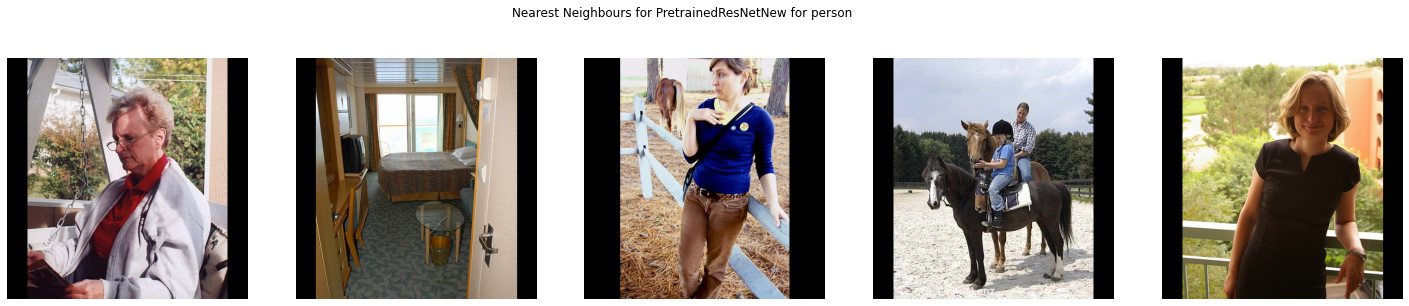

> <ipython-input-6-4b2b2ed27b82>(16)get_nearestNeighbours()
     15             import ipdb;ipdb.set_trace()
---> 16         fig = plt.figure(figsize=(25,5))
     17         fig.suptitle('Nearest Neighbours for {} for {}'.format(model.__class__.__name__,CLASS_NAMES[np.argmax(target_[x])]))

ipdb> c


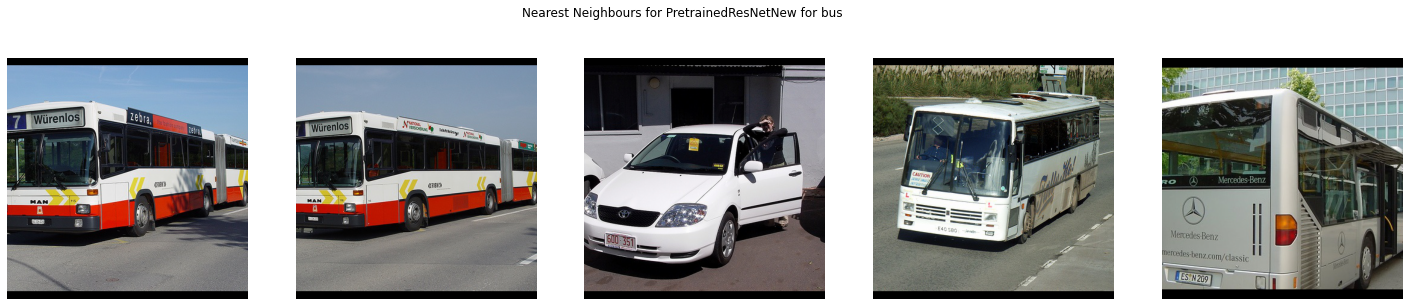

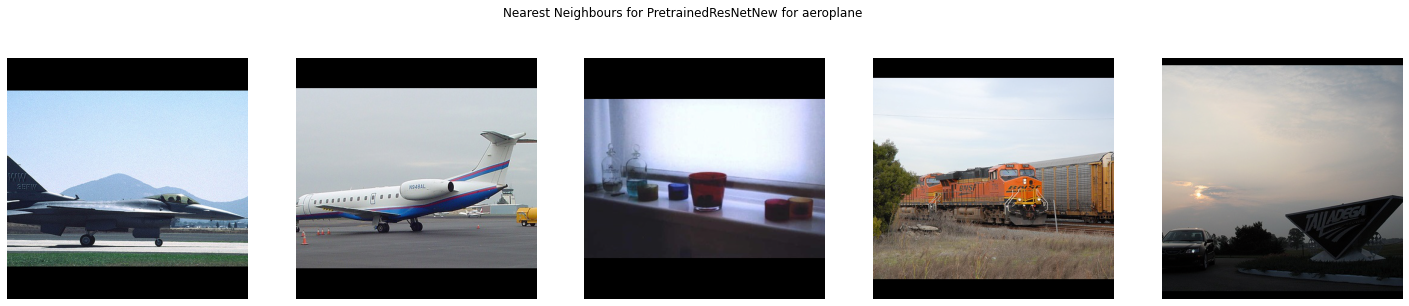

In [8]:
model=PretrainedResNetNew()
embeddings_R,imgs_R,target_R = load_data(model)
get_nearestNeighbours(embeddings_R,imgs_R,target_R)

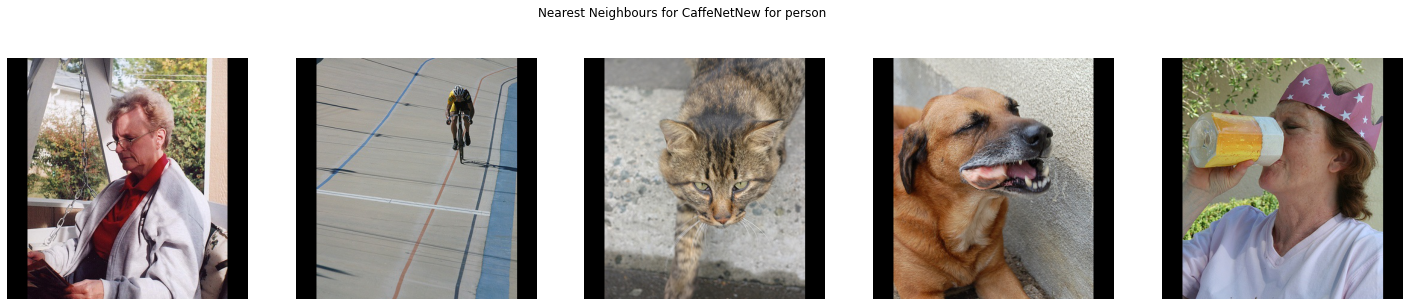

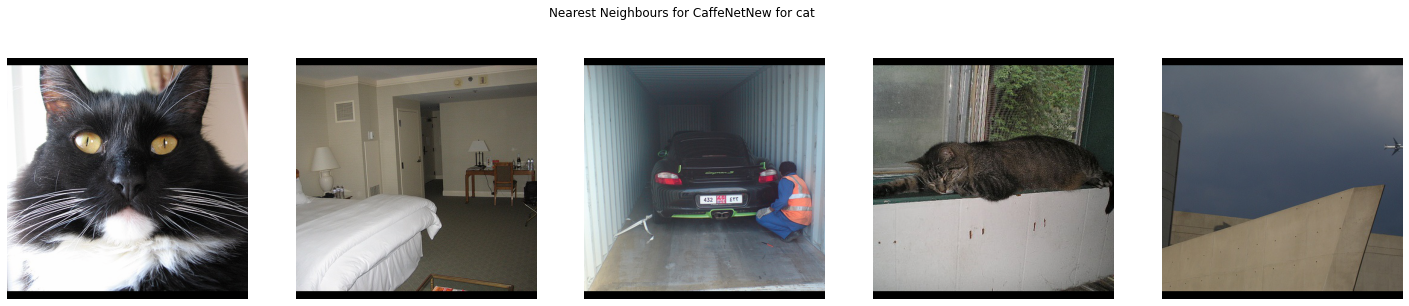

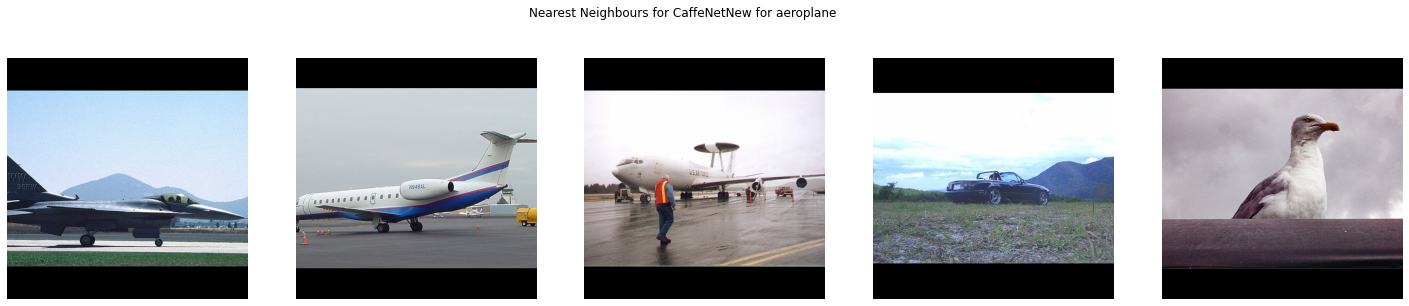

In [7]:
model=CaffeNetNew()
embeddings_C,imgs_C,target_C = load_data(model)
get_nearestNeighbours(embeddings_C,imgs_C,target_C)

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D t-SNE projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

In [6]:
args = ARGS(epochs=50, use_cuda=True,batch_size=32,test_batch_size=100, lr=0.0001,val_every=250,gamma=0.95,save_freq=5)
test_loader = utils.get_data_loader('voc', train=False, batch_size=args.test_batch_size, split='test')
model = CaffeNet()
PATH = 'CaffeNet/models/49_.pt'
model.load_state_dict(torch.load(PATH))
model.fc_layers = nn.Sequential(*list(model.fc_layers.children())[:-3])
model.eval()
model = model.to(args.device)
num_imgs = 0
data_ = []
target_ = []
embeddings = []
# plot t-SNE here
with torch.no_grad():
    for data, target, wgt in test_loader:
        data, target = data.to(args.device), target.to(args.device)
        emb = model(data)
        embeddings.append(emb.detach().cpu().numpy())
        target_.append(target.detach().cpu().numpy())

        num_imgs += args.test_batch_size
        if num_imgs >= 1000:
            break
embeddings = np.array(embeddings)
embeddings = np.row_stack(embeddings)
target_ = np.row_stack(target_)
imgs = np.array(data_)


(1000, 2) (20, 3)


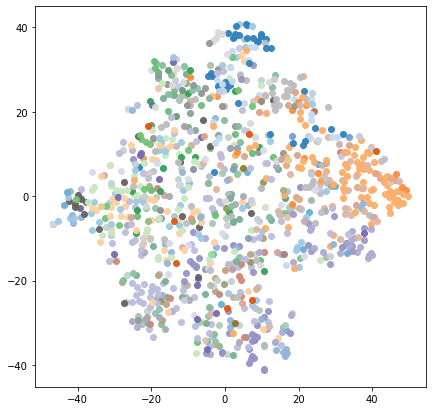

In [54]:
tsne = TSNE(2, verbose=0)
tsne_proj = tsne.fit_transform(embeddings)
cmap = cm.get_cmap('tab20c') #tab20b very similar
fig, ax = plt.subplots(figsize=(7,7))
num_categories = len(VOCDataset.CLASS_NAMES)
colours=[]
for i in range(num_categories):
    colours.append(np.array(cmap(i)).reshape(1,4)[:,:3])
colours = np.vstack(colours) 
#     print(cmps)
print(tsne_proj.shape, colours.shape)
for inx in range(tsne_proj.shape[0]):
    class_= target_[inx]
    colr = colours[np.where(class_ == 1)]/np.sum(class_)
    colr = np.sum(colr, axis =0 )
    ax.scatter(tsne_proj[inx,0],tsne_proj[inx,1], c=colr.reshape(1,-1) ,alpha=0.95)

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

**YOUR ANSWER HERE**

In [7]:
resnet = PretrainedResNet()
caffe = CaffeNet()
CAFFE_PATH = 'CaffeNet/models/49_.pt'
RESNET_PATH = 'PretrainedResNet/models/45_.pt'
caffe.load_state_dict(torch.load(CAFFE_PATH))
resnet.load_state_dict(torch.load(RESNET_PATH))


args = ARGS(epochs=50, use_cuda=True,batch_size=32,test_batch_size=100, lr=0.0001,val_every=250,gamma=0.95,save_freq=5)



In [8]:
caffe=caffe.to(args.device)
resnet=resnet.to(args.device)
resnet_ap, resnet_map_ = utils.eval_dataset_map(resnet, args.device, test_loader)
caffe_ap, caffe_map_ = utils.eval_dataset_map(caffe, args.device, test_loader)

In [21]:
resnet_ap_class = [item for item in zip(resnet_ap,VOCDataset.CLASS_NAMES)]
caffe_ap_class = [item for item in zip(caffe_ap,VOCDataset.CLASS_NAMES)]
print('Resnet AP for classes')
for item in sorted(resnet_ap_class,reverse=True):
    print(item)
print('Caffe AP for classes')
for item in sorted(caffe_ap_class,reverse=True):
    print(item) 

Resnet AP for classes
(0.9581020108081073, 'person')
(0.9497382672696933, 'aeroplane')
(0.9482830014176387, 'horse')
(0.9347473679714113, 'train')
(0.926710831438176, 'bird')
(0.9245596770968487, 'cat')
(0.8930195702029534, 'car')
(0.8917271879890027, 'bicycle')
(0.8888425442825904, 'dog')
(0.8685390753472412, 'boat')
(0.8607849551091846, 'motorbike')
(0.8396333956066071, 'bus')
(0.7865415219873935, 'sheep')
(0.7813374550422902, 'diningtable')
(0.7784709655763647, 'cow')
(0.7109032059431017, 'tvmonitor')
(0.6555731495302576, 'sofa')
(0.5527218366584812, 'pottedplant')
(0.530838917738938, 'bottle')
(0.5033623564340799, 'chair')
Caffe AP for classes
(0.7587868836555735, 'person')
(0.5561403740186877, 'car')
(0.4066247298908081, 'train')
(0.38967866136590773, 'horse')
(0.34581529225648117, 'aeroplane')
(0.28892900228039253, 'motorbike')
(0.26909791181548715, 'cat')
(0.2322262610260117, 'bicycle')
(0.22190815187425075, 'tvmonitor')
(0.21689437812801013, 'dog')
(0.21594774290804233, 'bird')

In the PASCAL dataset, the class person has a lot of images and so allows for a lot of samples for the network to classify the class correctly. On the other hand there are a lot of ambiguities for some classes.
Some of the images with bottles dont have any unique features and are hard to find.
Car seems to gain a bit of advantage from pretrained Resnet. Reason could be that imagenet contains images of cars.